In [248]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 20,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load Stephanie's Praesepe catalogue

In [249]:
douglas = pd.read_csv("../data/praesepe_douglas.csv", skiprows=89)
douglas.head()

,Name,EPIC,Mass,r'mag,Kmag,Prot1,Pw1,Q1,Clean?,Sig,...,SmAmp,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE
0,KW547,211898181,1.05,11.65,9.70,,,2,,,...,,,11.68,0,0,All,2M,Simbad,130.157851,18.700121
1,A 448,211845572,0.15,18.59,14.57,,,2,,,...,,,17.36,0,0,All,2M,Simbad,129.143078,17.957611
2,KW548,212004731,0.80,11.81,10.59,3.96,0.1085,0,N,0.00838,...,0.02363,2,11.79,0,0,All,2M,Simbad,130.815494,20.333748
3,JC201,211930461,0.73,13.49,10.76,14.59,0.8391,0,Y,0.00816,...,0.38429,2,13.49,0,1,All,2M,Simbad,130.088905,19.181773
4,,212094548,0.16,19.52,14.25,6.60,0.0089,1,N,0.00521,...,0.77485,2,18.71,0,1,All,2M,Simbad,130.281121,21.915739


In [250]:
periods = []
for p in douglas.Prot1.values:
    if p == "     ":
        periods.append(0.)
    else:
        periods.append(float(p))
douglas["period"] = np.array(periods)

(1.5, 0.1)

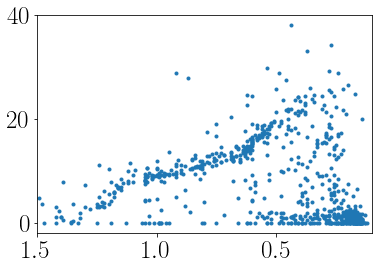

In [251]:
plt.plot(douglas.Mass, douglas.period, ".")
plt.xlim(1.5, 0.1)

Load the Gaia crossmatch for the clusters

In [252]:
gaia = pd.read_csv("../data/gaia_cluster_crossmatch.csv", skiprows=49)
m = gaia.Cluster.values == "Praesepe"
pg = gaia.iloc[m]
pg.head()
pg["source_id"] = pg.Source
print(np.shape(pg))
pg.head()

(938, 10)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Source,Cluster,RA_ICRS,DE_ICRS,Gmag,plx,e_plx,_RA.icrs,_DE.icrs,source_id
1994,685747814353991296,Praesepe,133.15933,21.15502,15.859,5.639,0.034,133.15933,21.15502,685747814353991296
1995,665141141087298688,Praesepe,130.22501,21.75663,18.489,5.629,0.020,130.22501,21.75663,665141141087298688
1996,665203233431193344,Praesepe,129.73385,21.94080,18.440,5.334,0.055,129.73385,21.94080,665203233431193344
1997,664963024499946496,Praesepe,130.84387,21.67163,10.404,5.556,0.040,130.84387,21.67163,664963024499946496
1998,664976218639479296,Praesepe,130.76188,21.75375,17.337,6.153,0.093,130.76188,21.75375,664976218639479296


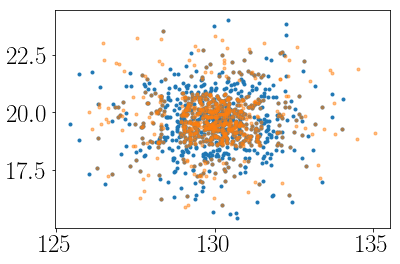

In [253]:
plt.plot(pg.RA_ICRS, pg.DE_ICRS, ".")
plt.plot(douglas._RA, douglas._DE, ".", alpha=.5)

In [254]:
def find_min_dist(ra1, dec1, ra2, dec2, dist_arcsecs=5.):
    """
    ind1 is a list of indices the same length as ra1 and dec1 that identifies matching stars in ra1 and dec1.
    ind2 is a list of indices the same length as ra2 and dec2 that identifies matching stars in ra2 and dec2.
    """
    id1, id2 = np.ones((len(ra1)))*np.nan, np.ones((len(ra2)))*np.nan
    ind1, ind2 = [], []
    for i in tqdm(range(len(ra1))):
        e2 = np.sqrt((ra2.values - ra1.values[i])**2 + (dec2.values - dec1.values[i])**2)
        min_distance = min(e2)
        if min_distance < dist_arcsecs/3600.:
            m = e2 == min_distance
            if sum(m) > 1:  # If there is a star (a) within 5 arcsecs of this target star (i)
                m = np.arange(len(ra2))[m[0]]  # create an index mask, selecting the position of star a
            if not np.arange(len(ra2))[m] in np.array(ind2):  # If this star has not already been identified
                ind1.append(i)  # add i to the list of inds1
                ind2.append(np.arange(len(ra2))[m])  # Add a to the list of inds2
                id1[i] = i
                id2[m] = i
    
    m1, m2 = np.zeros(len(ra1), dtype="bool"), np.zeros(len(ra2), dtype="bool")
    for i in ind1:
        m1[i] = True
    for i in ind2:
        m2[i] = True
    return m1, m2, id1, id2

100%|██████████| 938/938 [00:01<00:00, 607.07it/s]


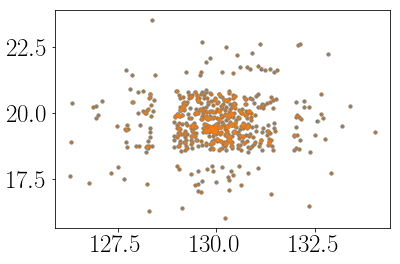

In [255]:
inds1, inds2, id1, id2 = find_min_dist(pg.RA_ICRS, pg.DE_ICRS, douglas._RA, douglas._DE)
plt.plot(pg.RA_ICRS.values[inds1], pg.DE_ICRS.values[inds1], ".")
plt.plot(douglas._RA.values[inds2], douglas._DE.values[inds2], ".", alpha=.5)

In [256]:
pg["id"] = id1
douglas["id"] = id2

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


4.0 4.0


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


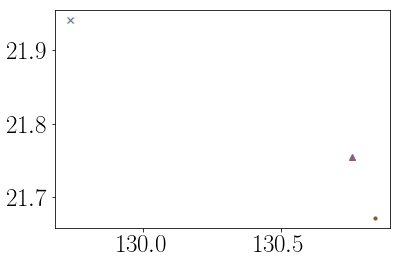

In [257]:
print(min(pg.id.values[pg.id.values > 3]), min(douglas.id.values[douglas.id.values > 3]))
m1 = pg.id.values == 2
m2 = douglas.id.values == 2
plt.plot(pg.RA_ICRS.values[m1], pg.DE_ICRS.values[m1], "x")
plt.plot(douglas._RA.values[m2], douglas._DE.values[m2], "x", alpha=.5)

m1 = pg.id.values == 3
m2 = douglas.id.values == 3
plt.plot(pg.RA_ICRS.values[m1], pg.DE_ICRS.values[m1], ".")
plt.plot(douglas._RA.values[m2], douglas._DE.values[m2], ".", alpha=.5)

m1 = pg.id.values == 4
m2 = douglas.id.values == 4
plt.plot(pg.RA_ICRS.values[m1], pg.DE_ICRS.values[m1], "^")
plt.plot(douglas._RA.values[m2], douglas._DE.values[m2], "^", alpha=.5)

In [258]:
m1 = np.isfinite(pg.id.values)
m2 = np.isfinite(douglas.id.values)
df = pd.merge(pg.iloc[m1], douglas.iloc[m2], on="id", how="right")
print(np.shape(pg.iloc[m1]), np.shape(douglas.iloc[m2]), np.shape(df))

(549, 11) (549, 30) (549, 40)


In [259]:
source_ids_praesepe = pd.DataFrame(dict({"source_id": df.source_id}))
source_ids_praesepe.to_csv("../data/source_ids_praesepe.csv")

Log in here: https://gea.esac.esa.int/archive/

After performing the following query with the above data file uploaded:

SELECT *

FROM user_table_name

JOIN gaiadr2.gaia_source AS gaia USING (source_id)

Load gaia table.

In [260]:
gaia = pd.read_csv("../data/praesepe-result.csv")

In [261]:
df2 = pd.merge(gaia, df, on="source_id")
# for i in df2.keys():
#     print(i)

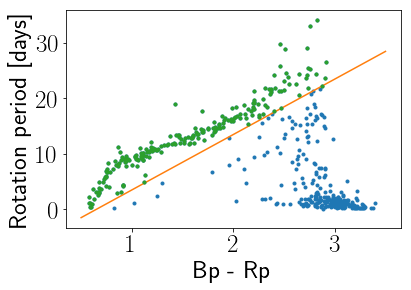

In [262]:
m = df2.period.values > 0.
m &= np.isfinite(df2.phot_bp_mean_mag.values - df2.phot_rp_mean_mag.values)
m &= np.isfinite(df2.period.values)

df2 = df2.iloc[m]

x = df2.phot_bp_mean_mag.values - df2.phot_rp_mean_mag.values
y = df2.period.values

plt.plot(x, y, ".")
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

xs = np.linspace(.5, 3.5, 100)
plt.plot(xs, 10*xs - 6.5)

m = 10*x - 6.5 < y 
plt.plot(x[m], y[m], ".")

In [263]:
A = np.vander(x[m], 6)
ATA = np.dot(A.T, A)
p = np.linalg.solve(ATA, np.dot(A.T, y[m]))

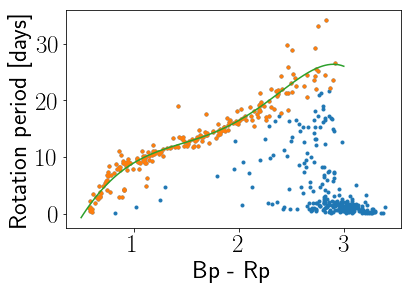

In [264]:
plt.plot(x, y, ".")
plt.plot(x[m], y[m], ".")
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

xs = np.linspace(.5, 3, 100)
plt.plot(xs, np.polyval(p, xs))

Now in log space.

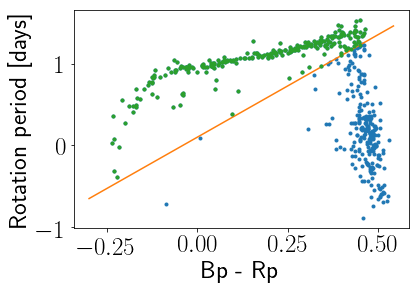

In [265]:
plt.plot(np.log10(x), np.log10(y), ".")
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

xs = np.linspace(np.log10(.5), np.log10(3.5), 100)
plt.plot(xs, 2.5*xs + .1)

m = 2.5*np.log10(x) + .1 < np.log10(y) 
plt.plot(np.log10(x[m]), np.log10(y[m]), ".")

x1, y1 = np.log10(x[m]), np.log10(y[m])
x2, y2 = np.log10(x[~m]), np.log10(y[~m])

praesepe_no_outliers = df2.iloc[m]

In [266]:
A = np.vander(x1, 6)
ATA = np.dot(A.T, A)
pr = np.linalg.solve(ATA, np.dot(A.T, y1))

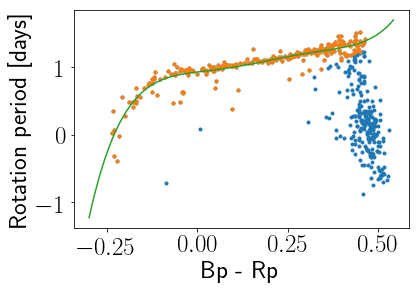

In [267]:
plt.plot(np.log10(x), np.log10(y), ".")
plt.plot(x1, y1, ".")
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

plt.plot(xs, np.polyval(pr, xs))

What is the scatter about the line?

0.012477919076642991


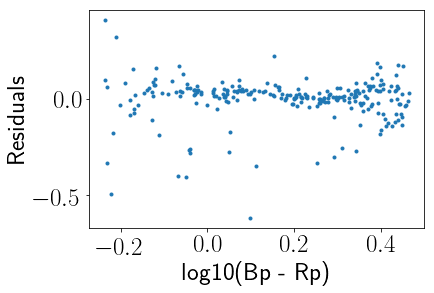

In [268]:
resids = y1 - np.polyval(pr, x1)
plt.plot(x1, resids, ".")
plt.xlabel("log10(Bp - Rp)")
plt.ylabel("Residuals")
var = np.var(resids)
std = np.sqrt(var)
print(var)

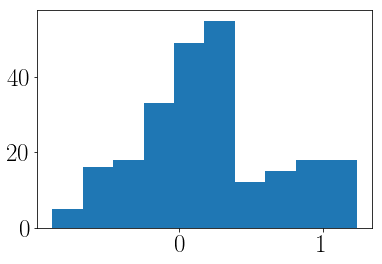

In [269]:
plt.hist(y2);

Generate data that look similar to this.

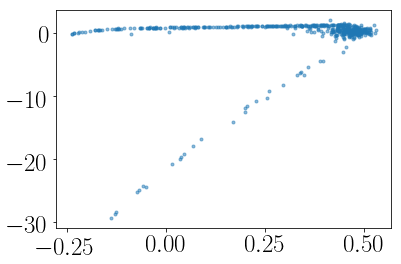

In [270]:
# Select some stars to be outliers
f = .1  # outlier fraction
random = np.random.uniform(0, 1, len(x1))
m = random > f  # m masks out the outliers. 

# Rotation main sequence                              # noise standard deviation
y1_model = np.polyval(pr, x1) + np.random.randn(len(x1)) * (std/3)#  + .1*x1)
plt.plot(x1[m], y1_model[m], ".", alpha=.5)

# Outliers
# y3 = np.polyval(p, x1[~m]) - np.random.uniform(0, 1, len(x1[~m]))
y3 = np.polyval(p, x1[~m]) - np.abs(np.random.randn(len(x1[~m]))*.5) # + .8)
plt.plot(x1[~m], y3, ".", color="tab:blue", alpha=.5)

# M dwarfs
y2_model = np.random.randn(len(x2))*.5 + .4
plt.plot(x2, y2_model, ".", color="tab:blue", alpha=.5)

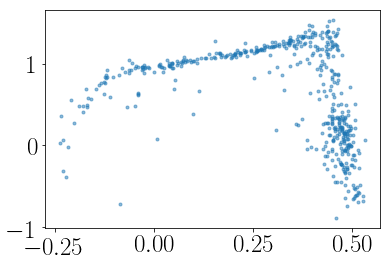

In [271]:
plt.plot(np.log10(x), np.log10(y), ".", alpha=.5)

Just look at the M dwarfs

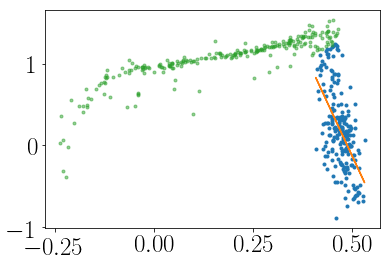

In [272]:
m = x2 > .4
plt.plot(x2[m], y2[m], ".")

A = np.vander(x2[m], 2)
ATA = np.dot(A.T, A)
p = np.linalg.solve(ATA, np.dot(A.T, y2[m]))
plt.plot(x2[m], np.polyval(p, x2[m]))

plt.plot(x1, y1, ".", alpha=.5)

Load the Hyades

In [273]:
hyades = pd.read_csv("../data/hyades_compilation.csv")

Text(0,0.5,'Rotation period [days]')

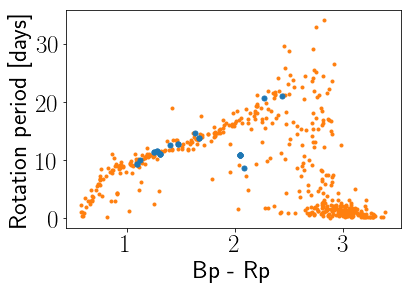

In [274]:
m = hyades.prot > 0.
m &= hyades.radial_velocity > 30.
plt.plot(hyades.bp[m] - hyades.rp[m], hyades.prot[m], ".", ms=10, zorder=1)

plt.plot(x, y, ".", zorder=0)
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

Load Pleiades data.

In [336]:
pleiades_rebull = pd.read_csv("../data/pleiades_rebull.csv", skiprows=70)
pleiades_rebull.head()

,EPIC,RAJ2000,DEJ2000,Vmag,Ksmag,(V-K)0,Prot,Per2,Per3,Per4,Amp,LC,Mm,LPer,H10,vsini,PapIII,PapII,Fig
0,210991540,52.95768,22.84023,,12.75,5.10,0.5749,,,,0.059,2,best,0.57,0,,1,1,Fig
1,211016313,53.03274,23.23265,,12.25,5.05,0.3193,,,,0.056,1,best,,0,,1,1,Fig
2,211029135,53.15753,23.43315,,13.06,5.76,0.2860,,,,0.032,4,best,,0,,1,1,Fig
3,211037397,53.17625,23.56679,,12.54,5.58,0.4990,0.3167,,,0.023,1,best,,0,,1,1,Fig
4,210946764,53.27427,22.13423,11.36,9.43,1.82,5.7660,,,,0.011,4,best,,0,,1,1,Fig


Load Bedell's catalogue.

In [337]:
bedell = pd.read_csv("K2_c4_gaia.csv")

In [338]:
pleiades = pd.merge(pleiades_rebull, bedell, on="EPIC")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


(-0.3, 0.6)

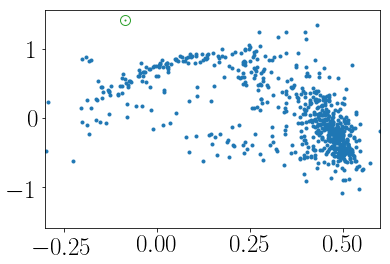

In [339]:
plt.plot(np.log10(pleiades.bp - pleiades.rp), np.log10(pleiades.Prot), ".")
plt.plot(np.log10(x), np.log10(y), ".")

plt.plot(np.log10(0.82), np.log10(26), "o", color="w", markeredgecolor="tab:green", ms=10)
plt.plot(np.log10(0.82), np.log10(26), ".", color="tab:green", ms=2)
plt.xlim(-.3, .6)

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


(-0.3, 0.3)

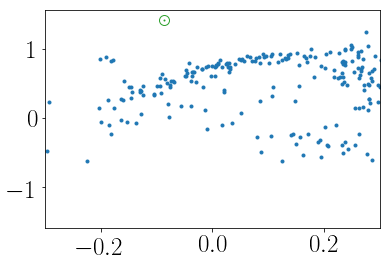

In [340]:
plt.plot(np.log10(pleiades.bp - pleiades.rp), np.log10(pleiades.Prot), ".")
plt.plot(np.log10(x), np.log10(y), ".")

plt.plot(np.log10(0.82), np.log10(26), "o", color="w", markeredgecolor="tab:green", ms=10)
plt.plot(np.log10(0.82), np.log10(26), ".", color="tab:green", ms=2)
plt.xlim(-.3, .3)

Iteratively remove those outliers

IndexError: indices are out-of-bounds

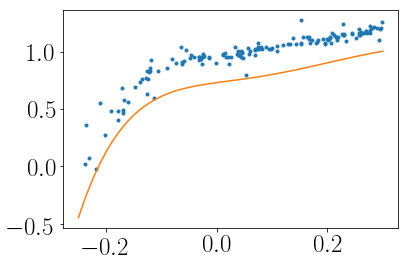

In [341]:
mpr = y1 > np.polyval(pr, x1) - .2
mpr &= x1 < 0.3
plt.plot(x1[mpr], y1[mpr], ".")
plt.plot(xs, np.polyval(pr, xs) - .2)

praesepe_no_outliers = praesepe_no_outliers.iloc[mpr]

In [ ]:
praesepe_no_outliers.to_csv("../data/praesepe_no_outliers.csv")

Do the same for the Pleiades.

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


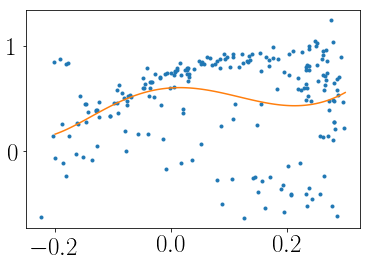

In [342]:
m = -.25 < np.log10(pleiades.bp - pleiades.rp)
m &= np.log10(pleiades.bp - pleiades.rp) < .3
xpl, ypl = np.log10(pleiades.bp[m] - pleiades.rp[m]), np.log10(pleiades.Prot[m])
plt.plot(xpl, ypl, ".")

A = np.vander(xpl, 6)
ATA = np.dot(A.T, A)
pl = np.linalg.solve(ATA, np.dot(A.T, ypl))

xs = np.linspace(-.2, .3, 100)
plt.plot(xs, np.polyval(pl, xs))

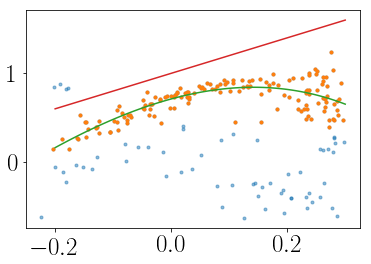

In [343]:
mpl = ypl > np.polyval(pl, xpl) - .2
mpl &= ypl < 2*xpl + 1

plt.plot(xpl, ypl, ".", alpha=.5)
plt.plot(xpl[mpl], ypl[mpl], ".")

A = np.vander(xpl[mpl], 4)
ATA = np.dot(A.T, A)
pl = np.linalg.solve(ATA, np.dot(A.T, ypl[mpl]))

plt.plot(xs, np.polyval(pl, xs))
plt.plot(xs, 2*xs + 1)

<function matplotlib.pyplot.close>

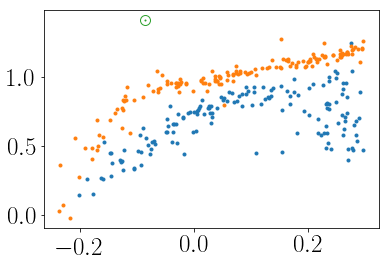

In [344]:
xpleiades, ypleiades = xpl[mpl], ypl[mpl]
xpraesepe, ypraesepe = x1[mpr], y1[mpr]
plt.plot(xpleiades, ypleiades, ".")
plt.plot(xpraesepe, ypraesepe, ".")

plt.plot(np.log10(0.82), np.log10(26), "o", color="w", markeredgecolor="tab:green", ms=10)
plt.plot(np.log10(0.82), np.log10(26), ".", color="tab:green", ms=2)
plt.close

Save the praesepe data.

# Now the NGC stars

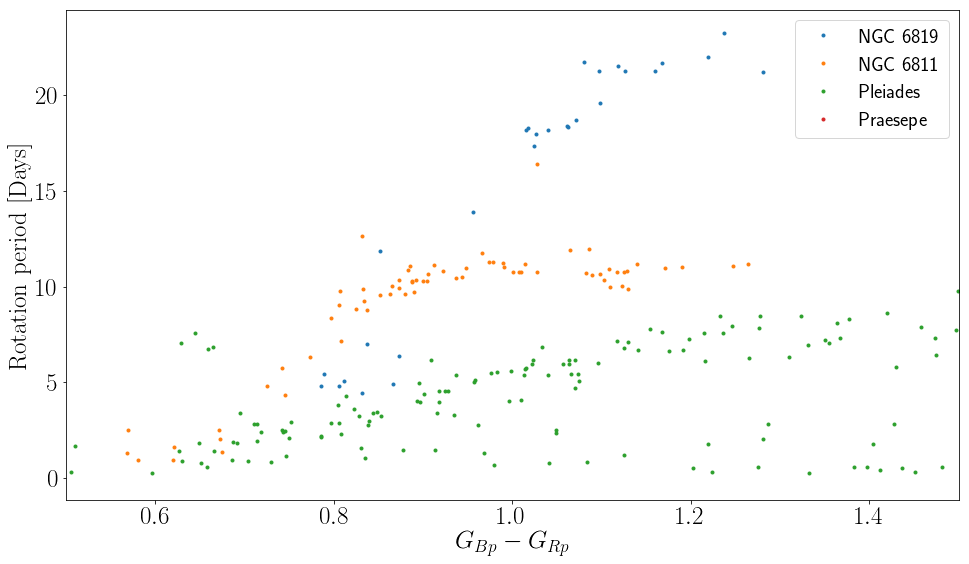

In [345]:
N19 = pd.read_csv("../data/NGC6819_gaia.csv")
N11 = pd.read_csv("../data/NGC6811_gaia.csv")

plt.figure(figsize=(16, 9))
plt.plot(N19.phot_bp_mean_mag - N19.phot_rp_mean_mag, N19.prot, ".", label="NGC 6819")
plt.plot(N11.phot_bp_mean_mag - N11.phot_rp_mean_mag, N11.Per, ".", label="NGC 6811")
plt.plot(pleiades.bp - pleiades.rp, pleiades.Prot, ".", label="Pleiades")
plt.plot(x, y, ".", label="Praesepe")
plt.xlim(.5, 1.5)
plt.xlabel("$G_{Bp} - G_{Rp}$")
plt.ylabel("$\mathrm{Rotation~period~[Days]}$")
plt.legend()

In [346]:
x19, y19 = np.log10(N19.phot_bp_mean_mag - N19.phot_rp_mean_mag), np.log10(N19.prot)
x11, y11 = np.log10(N11.phot_bp_mean_mag - N11.phot_rp_mean_mag), np.log10(N11.Per)
m = np.isfinite(x19)
m &= np.isfinite(y19)
x19, y19 = x19[m], y19[m]
m = np.isfinite(x11)
m &= np.isfinite(y11)
x11, y11 = x11[m], y11[m]

Now fit your model to the final data.

In [347]:
age_sun = np.log10(np.array([4.56e9]))
x_sun = np.array([np.log10(0.82)])
y_sun = np.array([np.log10(26)])

apr = np.log10(625.4e6)
apl = np.log10(150e6)
a19 = np.log10(2.5e9)
a11 = np.log10(1.1e9)
age_praesepe = np.ones((len(xpraesepe)))*apr
age_pleiades = np.ones((len(xpleiades)))*apl
age_19 = np.ones((len(x19)))*a19
age_11 = np.ones((len(x11)))*a11

x = np.concatenate((xpleiades, xpraesepe, x19, x11, x_sun))
y = np.concatenate((ypleiades, ypraesepe, y19, y11, y_sun))
z = np.concatenate((age_pleiades, age_praesepe, age_19, age_11, age_sun))

x = np.concatenate((xpraesepe, x_sun))
y = np.concatenate((ypraesepe, y_sun))
z = np.concatenate((age_praesepe, age_sun))

sigma = y*.00001  # 10% uncertainties
sigma[-1] = .00001  # Very precise for the Sun 

In [348]:
AT = np.vstack((np.ones(len(x)), x, x**2, x**3, x**4, z))
ATA = np.dot(AT, AT.T)
p = np.linalg.solve(ATA, np.dot(AT, y))
print(p)

# AT = np.vstack((np.ones(len(x)), x, x**2, x**3, x**4, z))
# C = np.eye(len(x)) * sigma**2

# ATC_invA = np.dot(AT, np.linalg.solve(C, AT.T))
# ATC_invy = np.dot(AT, np.linalg.solve(C, y))
# p = np.linalg.solve(ATC_invA, ATC_invy)

# err = np.sqrt(np.diag(np.linalg.inv(ATC_invA)))

[ -4.61268361   0.7116296   -3.05363255  28.04702555 -58.40916139
   0.63493869]


[26.]


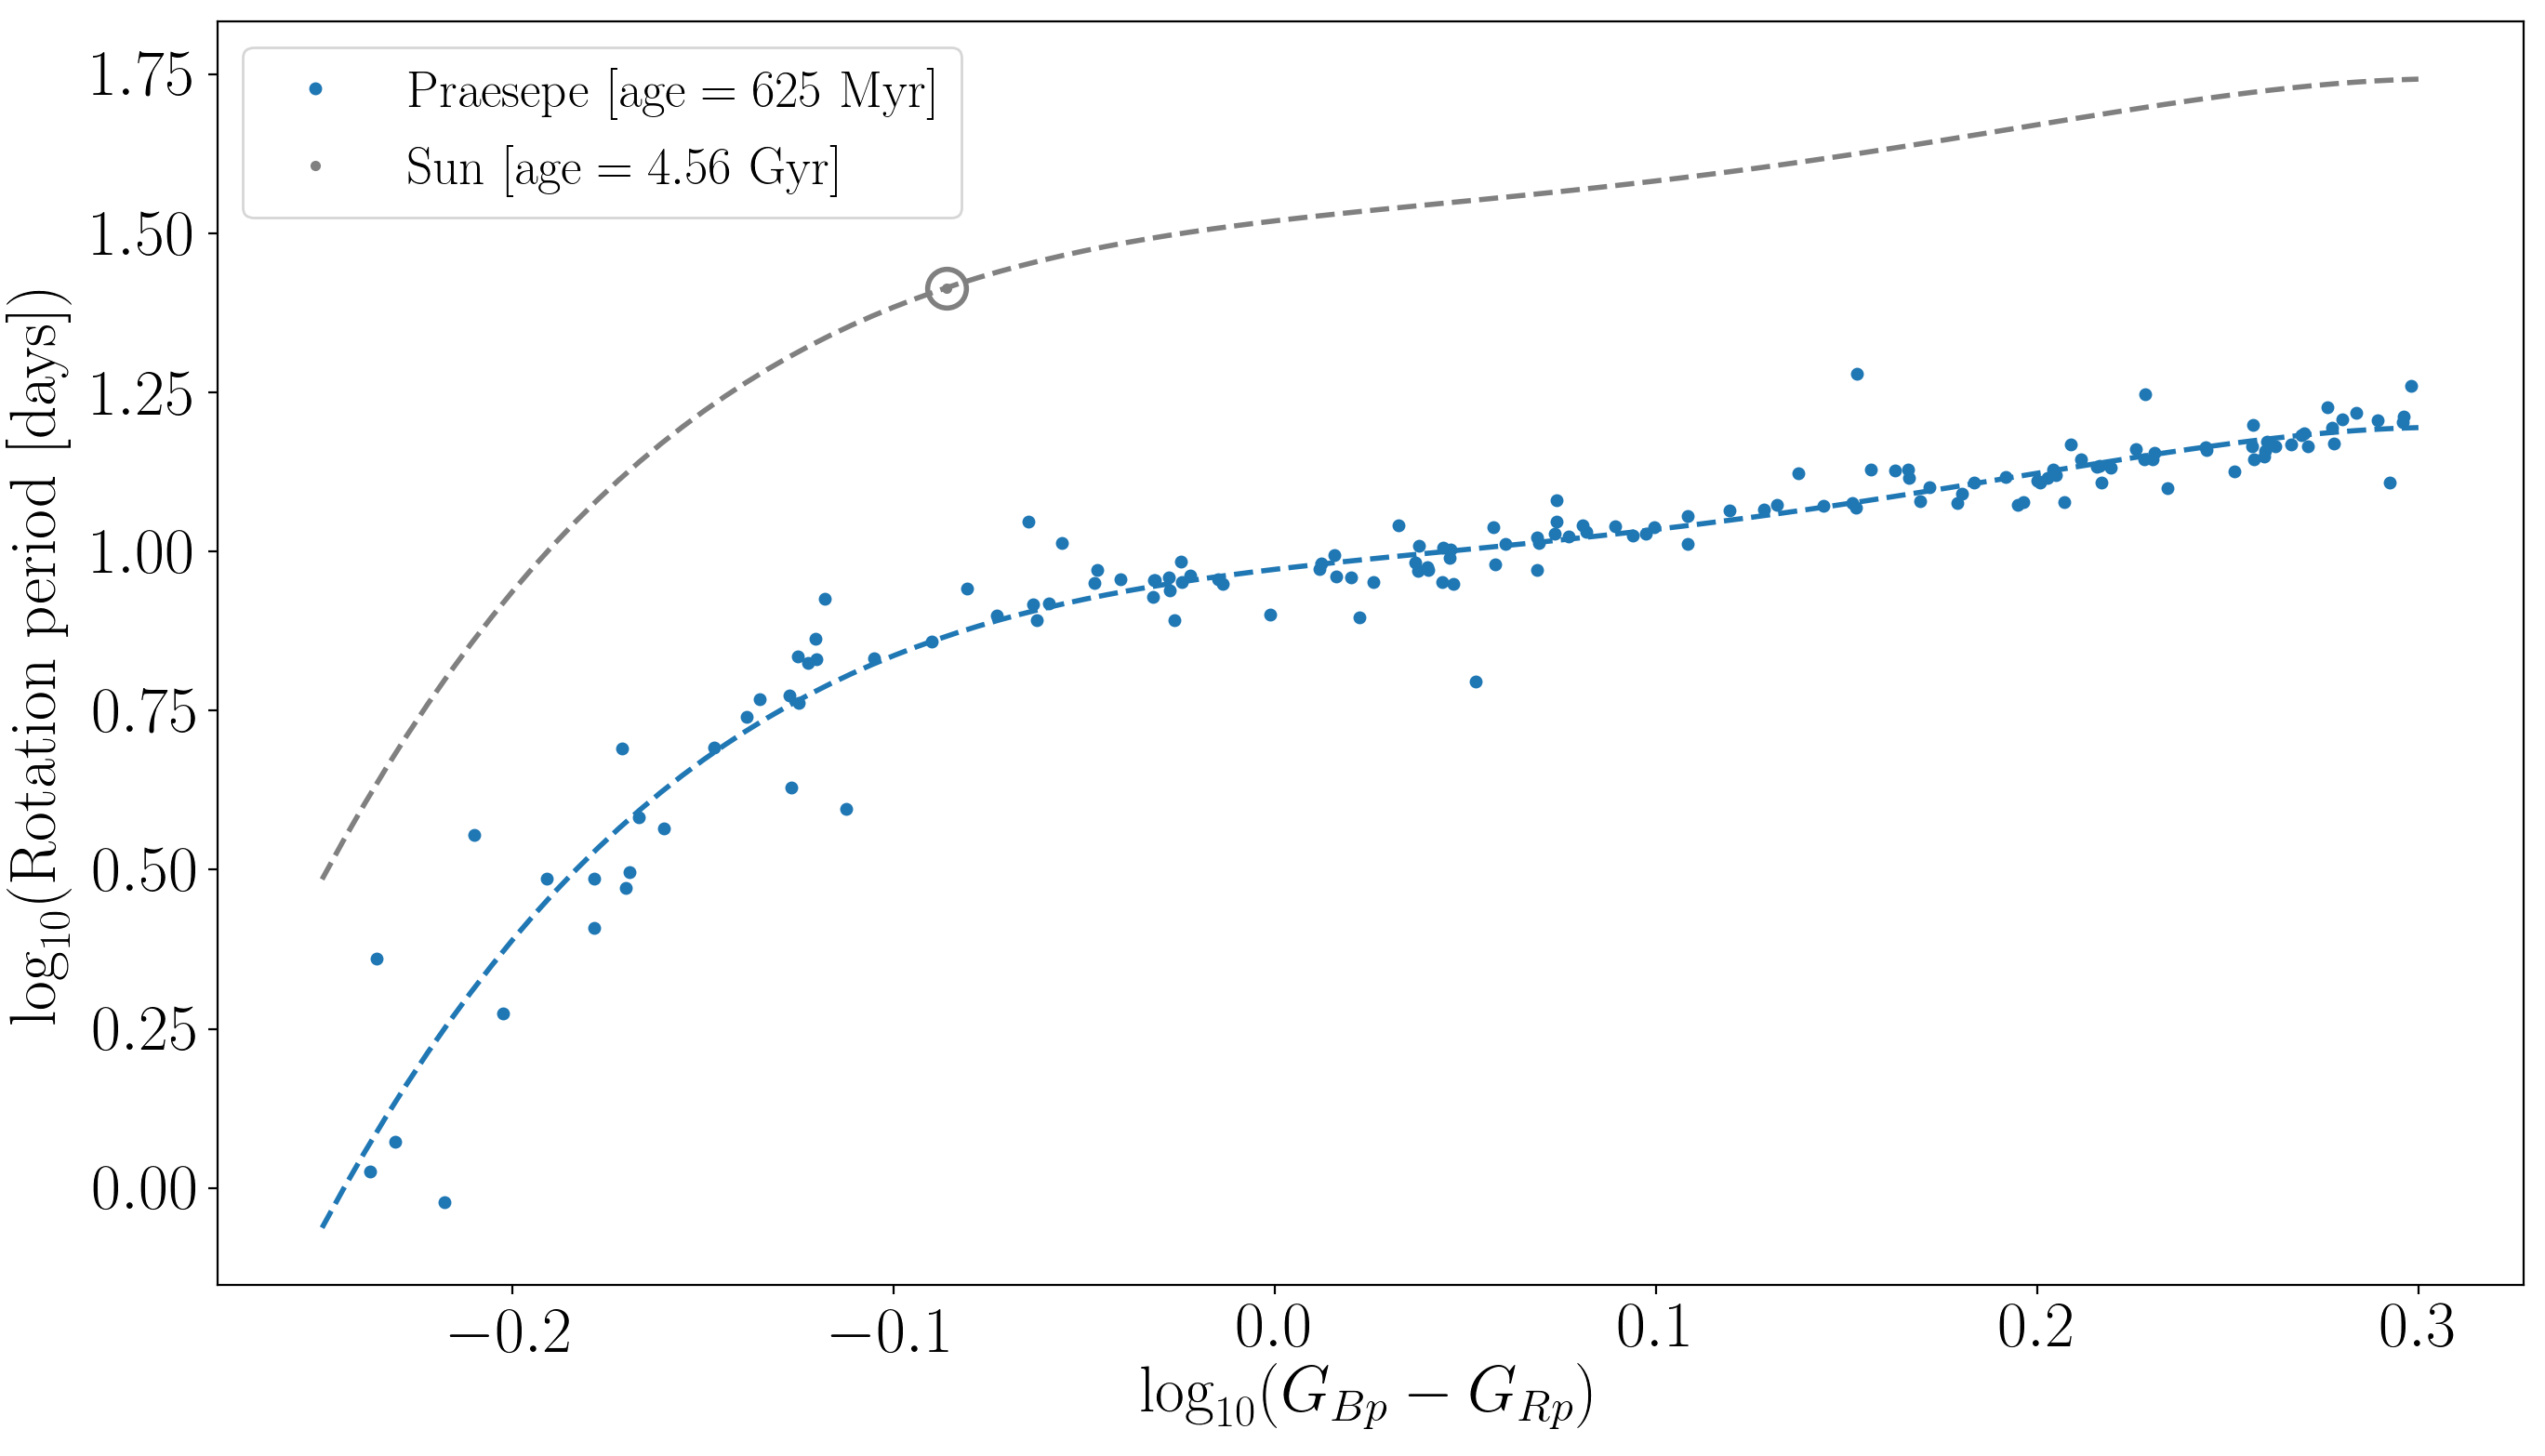

In [349]:
plt.clf()
plt.figure(figsize=(16, 9), dpi=200)

# Data
# plt.plot(xpleiades, ypleiades, ".", ms=8, label="$\mathrm{Pleiades~[age=150~Myr]}$")
plt.plot(xpraesepe, ypraesepe, ".", ms=8, color="tab:blue", label="$\mathrm{Praesepe~[age=625~Myr]}$")
# plt.plot(x19, y19, ".", ms=8, label="$\mathrm{NGC 6819~[age=2.5~Gyr]}$")
# plt.plot(x11, y11, ".", ms=8, label="$\mathrm{NGC 6811~[age=1.1~Gyr]}$")
plt.plot(x_sun, y_sun, "o", color="w", markeredgecolor=".5", markeredgewidth=2, ms=15)
plt.plot(x_sun, y_sun, ".", color=".5", ms=6, label="$\mathrm{Sun~[age=4.56~Gyr]}$")

# Models
xs = np.linspace(-.25, .3, 100)
# plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*apl)
#          color="tab:blue", ls="--", lw=2)
plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*apr,
         color="tab:blue", ls="--", lw=2)
plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*age_sun,
         color=".5", ls="--", lw=2)
# plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*a19)
#          color=".5", ls=":", lw=2)
# plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*a11)
#          color=".5", ls=":", lw=2)

psun = p[0] + p[1]*np.log10(0.82) + p[2]*np.log10(0.82)**2 + p[3]*np.log10(0.82)**3 + p[4]*np.log10(0.82)**4 + p[5]*age_sun
print(10**psun)

# Floof
plt.xlabel("$\log_{10}(G_{Bp} - G_{Rp})$")
plt.ylabel("$\log_{10}(\mathrm{Rotation~period~[days]})$")
plt.legend()

0.6349386883015732


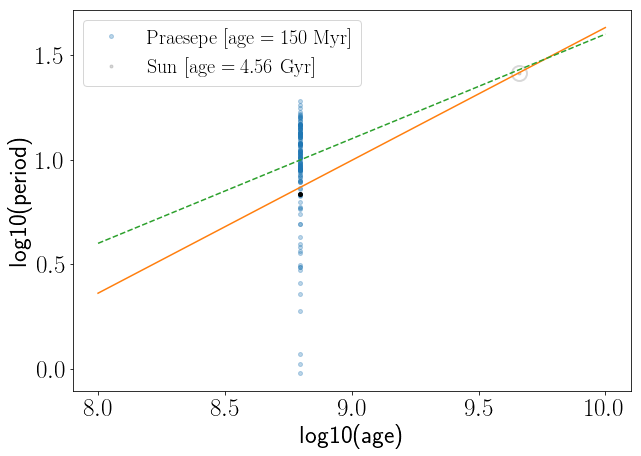

In [350]:
plt.figure(figsize=(10, 7))

# Data
# plt.plot(age_pleiades, ypleiades, ".", ms=8, label="$\mathrm{Pleiades~[age=625~Myr]}$", alpha=.3)
# mpl = -.15 < xpleiades
# mpl &= xpleiades < -.05
# plt.plot(age_pleiades[0], np.median(ypleiades[mpl]), "k.", ms=8)

plt.plot(age_praesepe, ypraesepe, ".", ms=8, label="$\mathrm{Praesepe~[age=150~Myr]}$", alpha=.3)
mpr = -.15 < xpraesepe
mpr &= xpraesepe < -.05
plt.plot(age_praesepe[0], np.median(ypraesepe[mpr]), "k.", ms=8)

# plt.plot(age_19, y19, ".", ms=8, label="$\mathrm{NGC 6819~[age=2.5~Gyr]}$", alpha=.3)
# m19 = -.15 < x19
# m19 &= x19 < -.05
# plt.plot(age_19[0], np.median(y19[m19]), "k.", ms=8)

# plt.plot(age_11, y11, ".", ms=8, label="$\mathrm{NGC 6811~[age=1.1~Gyr]}$", alpha=.3)
# m11 = -.15 < x11
# m11 &= x11 < -.05
# plt.plot(age_11[0], np.median(y11[m11]), "k.", ms=8)

plt.plot(age_sun, y_sun, "o", color="w", markeredgecolor=".5", markeredgewidth=2, ms=15, alpha=.3)
plt.plot(age_sun, y_sun, ".", color=".5", ms=6, label="$\mathrm{Sun~[age=4.56~Gyr]}$", alpha=.3)
plt.xlabel("log10(age)")
plt.ylabel("log10(period)")
plt.legend()

# Models
xs = np.linspace(8, 10, 100)
color = np.log10(.82)
plt.plot(xs, p[0] + p[1]*color + p[2]*color**2 + p[3]*color**3 + p[4]*color**4 + p[5]*xs)# + p[6]*xs**2 + p[7]*xs**3, 
#          color="tab:blue", ls="--", lw=2)

# psun = p[0] + p[1]*color + p[2]*color**2 + p[3]*color**3 + p[4]*color**4 + p[5]*age_sun
# print(10**psun)
plt.plot(xs, -3.4 + xs*.5, "--")
print(p[5])

In [351]:
print(np.log10(.82))

-0.08618614761628333


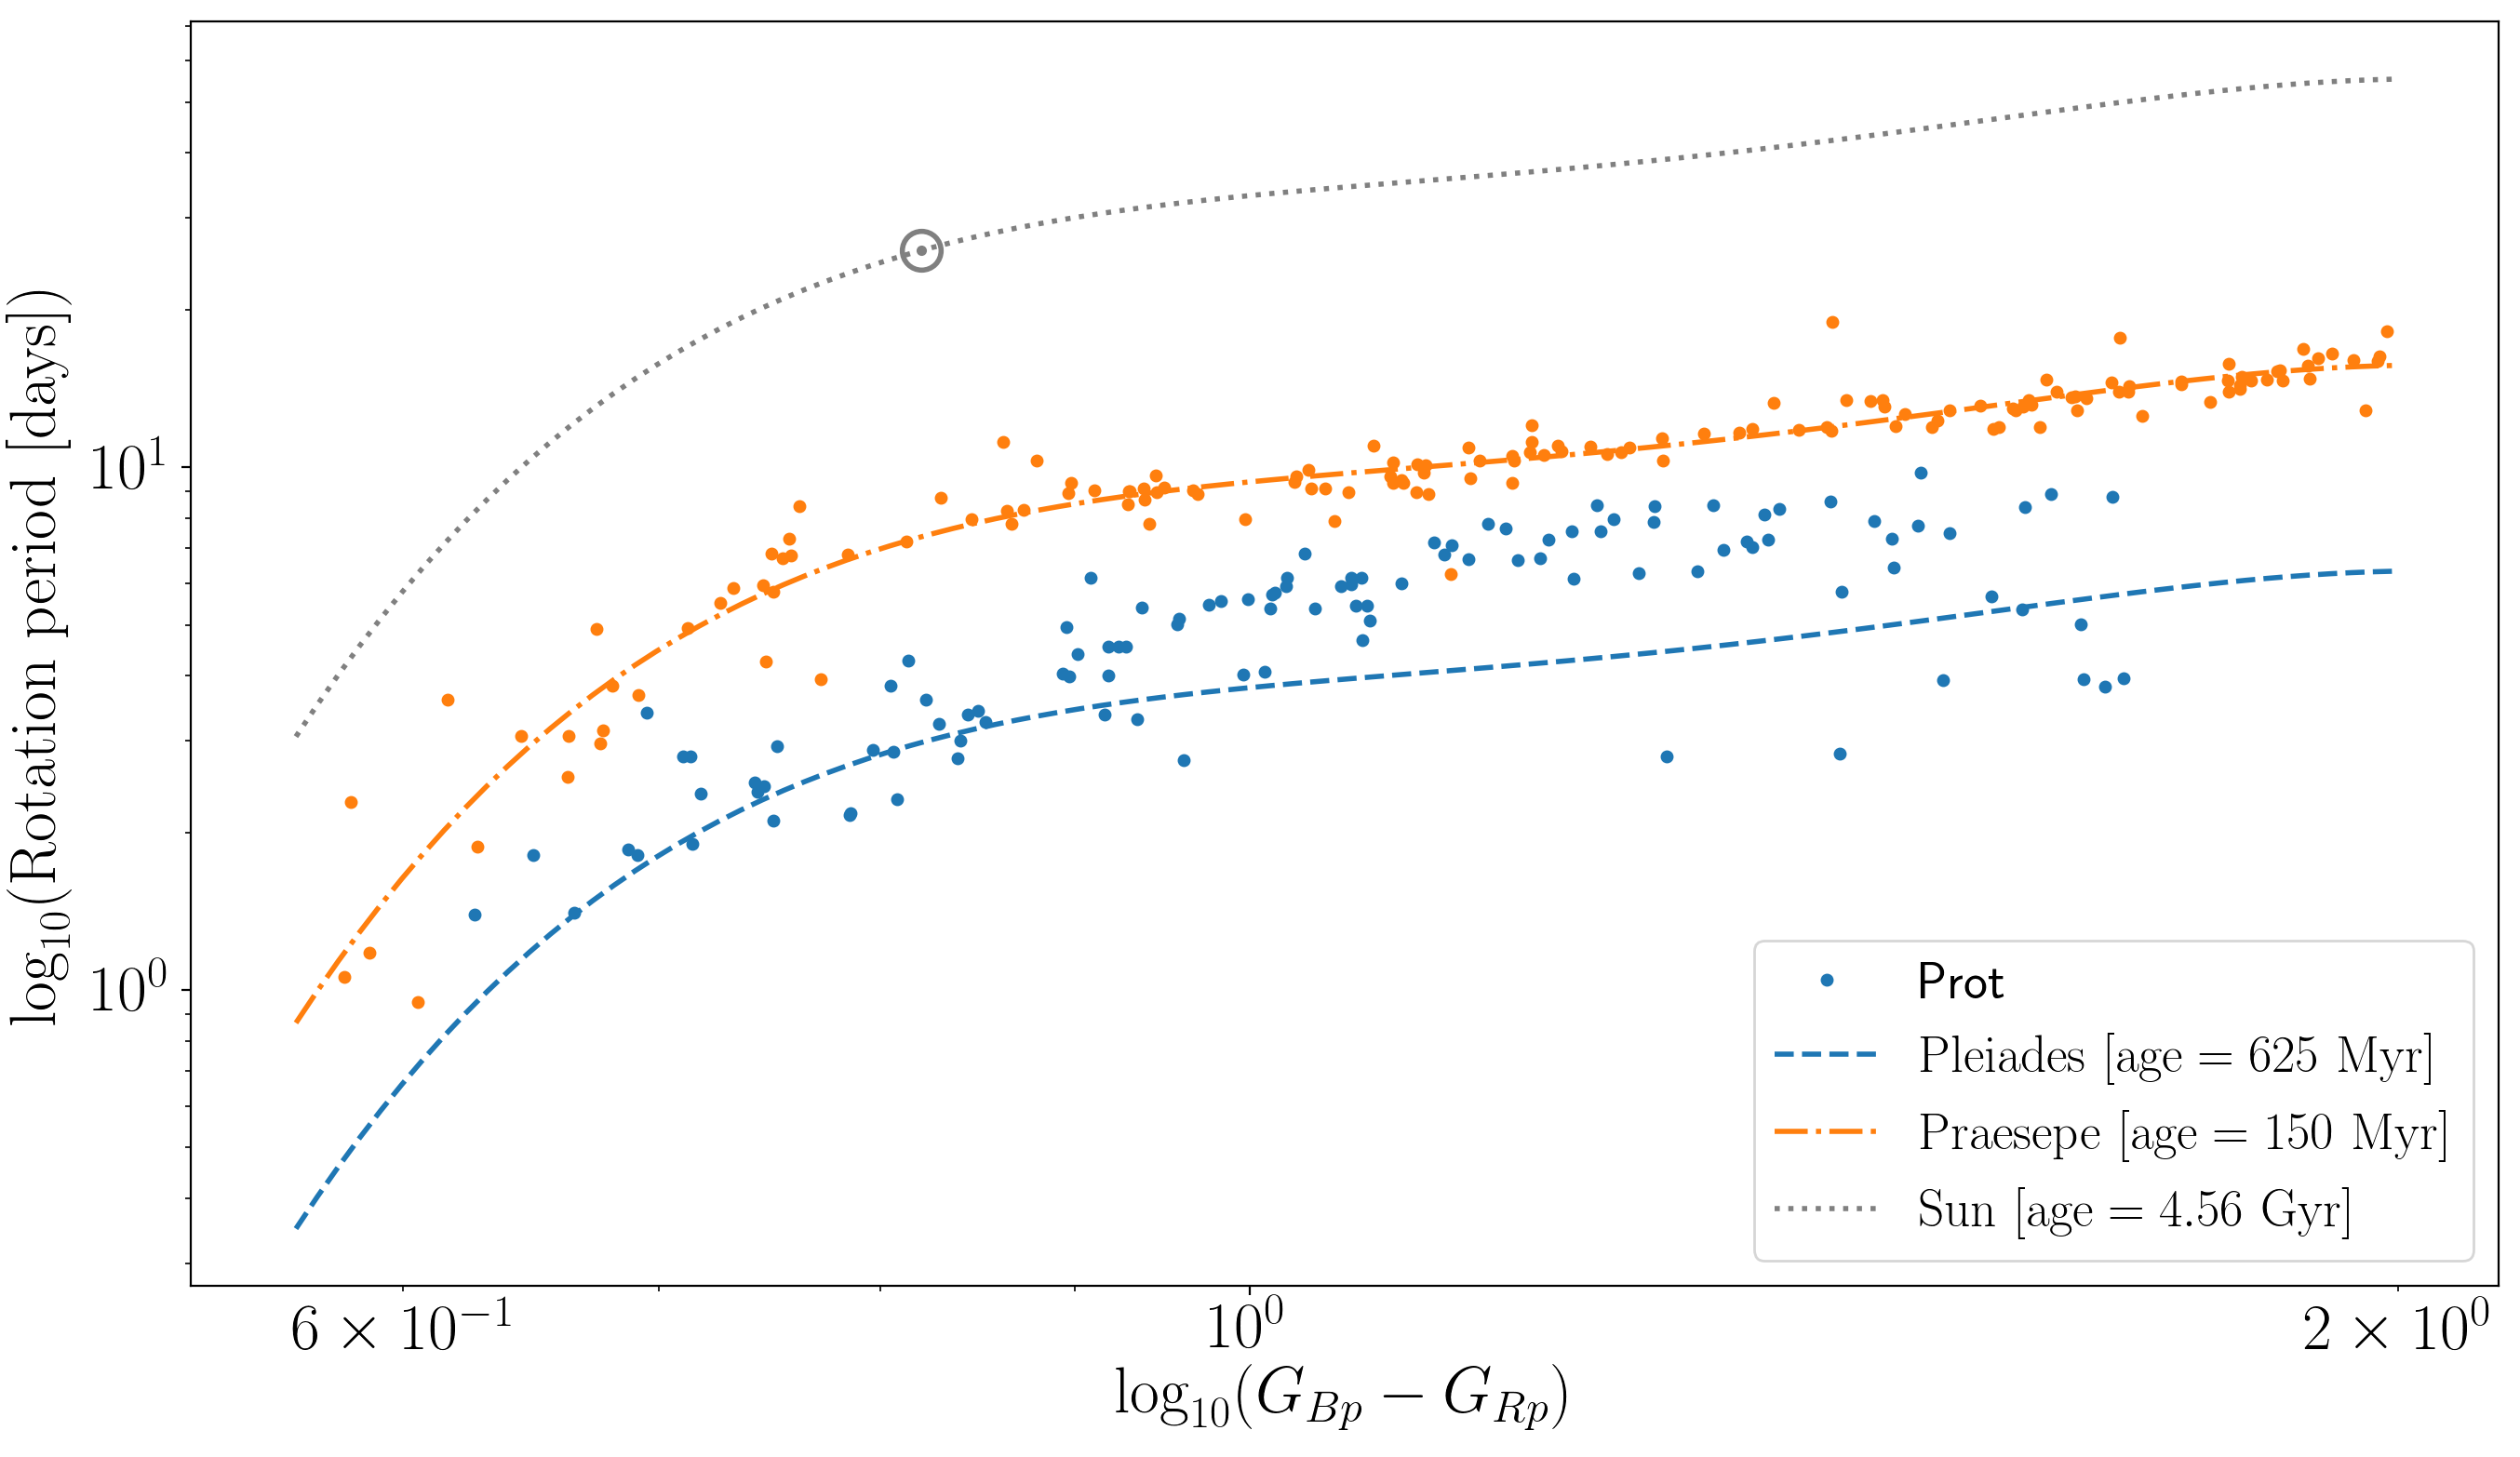

In [361]:
plt.clf()
plt.figure(figsize=(16, 9), dpi=200)

m = 10**xpleiades < 1.7

# Data
plt.loglog(10**xpleiades[m], 10**ypleiades[m], ".", ms=8)
plt.loglog(10**xpraesepe, 10**ypraesepe, ".", ms=8)
plt.loglog(10**x_sun, 10**y_sun, "o", color="w", markeredgecolor=".5", markeredgewidth=2, ms=15)
plt.loglog(10**x_sun, 10**y_sun, ".", color=".5", ms=6)

# Models
xs = np.linspace(-.25, .3, 100)
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*apl), 
         color="tab:blue", ls="--", lw=2, label="$\mathrm{Pleiades~[age=625~Myr]}$")
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*apr), 
         color="tab:orange", ls="-.", lw=2, label="$\mathrm{Praesepe~[age=150~Myr]}$")
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*age_sun),
         color=".5", ls=":", lw=2, label="$\mathrm{Sun~[age=4.56~Gyr]}$")

# Floof
plt.xlabel("$\log_{10}(G_{Bp} - G_{Rp})$")
plt.ylabel("$\log_{10}(\mathrm{Rotation~period~[days]})$")
plt.legend()

plt.savefig("../paper/clusters.pdf")

Now try using age as the y variable, color as x and rotation period as z.

In [362]:
x = np.concatenate((xpleiades[m], xpraesepe, x_sun))
z = np.concatenate((ypleiades[m], ypraesepe, y_sun))
y = np.concatenate((age_pleiades[m], age_praesepe, age_sun))

print(np.log10(650e6) - np.log10(650e6 - 1e6))
print(np.log10(650e6 + 1e6) - np.log10(650e6))

sigma = np.ones_like(y)*.07
sigma[-1] = .0007  # Very precise for the Sun

0.0006686598424856527
0.0006676319253369201


In [382]:
AT = np.vstack((np.ones(len(x)), x, x**2, x**3, x**4, z))
C = np.eye(len(y)) * sigma**2

ATC_invA = np.dot(AT, np.linalg.solve(C, AT.T))
ATC_invy = np.dot(AT, np.linalg.solve(C, y))
p = np.linalg.solve(ATC_invA, ATC_invy)

err = np.sqrt(np.diag(np.linalg.inv(ATC_invA)))

print(1./p[5])

0.6161090538519748


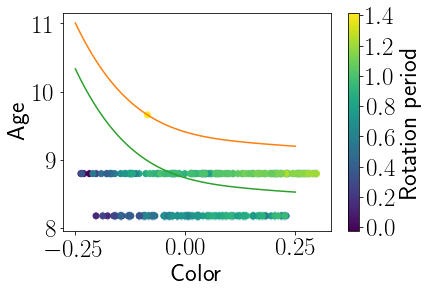

In [375]:
plt.errorbar(x, y, yerr=sigma, fmt=".", zorder=0, alpha=.1)
plt.scatter(x, y, c=z, zorder=1)
xs = np.linspace(-.25, .25, 100)
plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(26))
plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(10))
plt.xlabel("Color")
plt.ylabel("Age")
plt.colorbar(label="Rotation period")

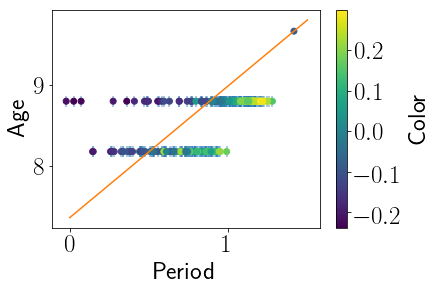

In [383]:
m = np.log10(.001) < z
m &= z < np.log10(100)
plt.errorbar(z[m], y[m], yerr=sigma[m], fmt=".", zorder=0, alpha=.5)
plt.scatter(z[m], y[m], c=x[m], zorder=1)
xs = np.linspace(0., 1.5, 100)
plt.plot(xs, p[0] + p[1]*np.log10(.82) + p[2]*np.log10(.82)**2 + p[3]*np.log10(.82)**3 
         + p[4]*np.log10(.82)**4 + p[5]*xs)
plt.xlabel("Period")
plt.ylabel("Age")
plt.colorbar(label="Color")

$$ \log_{10}(A) = a + b\log_{10}(C) + c\log_{10}(P) $$

$$ \log_{10}(P) = \frac{\log_{10}(A) - a - b\log_{10}(C)}{c}  $$

$$ \log_{10}(A) = a + b\log_{10}(C) + c\log_{10}^2(C) + d\log_{10}^3(C) + e\log_{10}^4(C) + f\log_{10}(P) $$

$$ \log_{10}(P) = \frac{\log_{10}(A) - a - b\log_{10}(C) - c\log_{10}^2(C) - d\log_{10}^3(C) - e\log_{10}^4(C)}{f}  $$

$$ \log_{10}(P) = \log_{10}(a) + n\log_{10}(A) + b\log_{10}(B-V-c)  $$
$$ a, b, c, n = [.4, .31, .45, .55] $$

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log10
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10


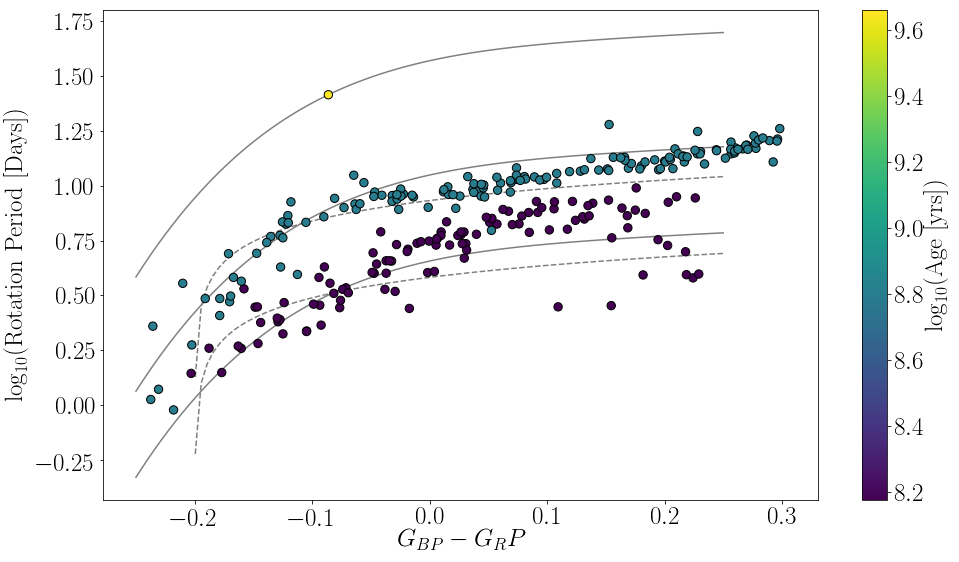

In [412]:
plt.figure(figsize=(16, 9))
plt.scatter(x, z, c=y, s=70, edgecolor="k", zorder=1)
xs = np.linspace(-.25, .25, 100)
plt.plot(xs, (np.log10(650e6) - p[0] - p[1]*xs - p[2]*xs**2 - p[3]*xs**3 - p[4]*xs**4)/p[5], color=".5", zorder=0)
plt.plot(xs, (np.log10(150e6) - p[0] - p[1]*xs - p[2]*xs**2 - p[3]*xs**3 - p[4]*xs**4)/p[5], color=".5", zorder=0)
plt.plot(xs, (np.log10(4.56e9) - p[0] - p[1]*xs - p[2]*xs**2 - p[3]*xs**3 - p[4]*xs**4)/p[5], color=".5", zorder=0)

a, b, c, n = .4, .31, .45, .55
plt.plot(xs, np.log10(a) + n*np.log10(650) + b*np.log10(xs+.2), "--", color=".5", zorder=0)
plt.plot(xs, np.log10(a) + n*np.log10(150) + b*np.log10(xs+.2), "--", color=".5", zorder=0)

plt.xlabel("$G_{BP} - G_RP$")
plt.ylabel("$\log_{10}(\mathrm{Rotation~Period~[Days]})$")
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yrs]})$")